In [11]:
%load_ext autoreload
%autoreload 2

import datetime
import gudhi
import numpy as np
import pandas as pd

from functions.data_processing import sublevelset_persistence, remove_outliers_z_score, remove_outliers_dbscan
from functions.data_loading import get_condensed_distance_matrix, flights_from_query, get_flight_persistances
from functions.plotting import plot_scatter_matrix

from scipy.cluster.hierarchy import fcluster, linkage
from matplotlib import pyplot as plt

from traffic.core import Traffic, Flight

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# load minimum data set
df = pd.read_csv("data/go_arounds_augmented.csv", low_memory=False)
df["time"] = pd.to_datetime(df["time"])

start = datetime.datetime(year=2019, month=1, day=1).replace(
    tzinfo=datetime.timezone.utc
)
stop = datetime.datetime(year=2020, month=3, day=1).replace(
    tzinfo=datetime.timezone.utc
)

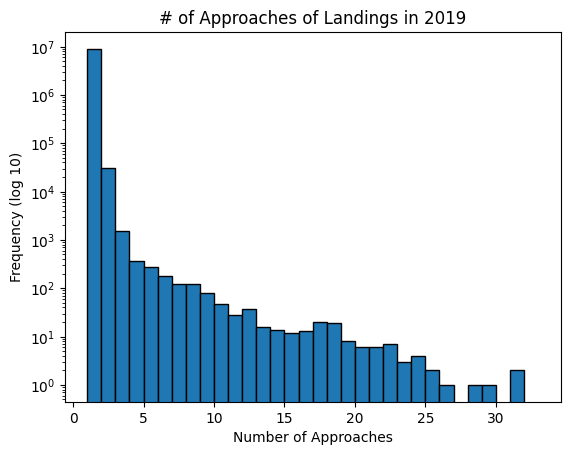

In [157]:
plt.figure()
plt.hist(df["n_approaches"], log=True, bins=range(1, 34), edgecolor = "black")
plt.xlabel("Number of Approaches")
plt.ylabel("Frequency (log 10)")
plt.title("# of Approaches of Landings in 2019")
plt.savefig("approach_histogram.svg", format="svg")
#plt.close()

In [137]:
with_GA = df.query(f"has_ga & (@start <= time <= @stop)")
without_GA = df.query(f"not has_ga & (@start <= time <= @stop)")

In [138]:
without_GA = without_GA.sample(n=with_GA.shape[0], random_state=42)
query = pd.concat([with_GA, without_GA], axis=0)

In [139]:
file_name = "balanced1_2"
flights, labels = flights_from_query(query, file_name, load_results=True)
data = get_flight_persistances(flights, file_name, load_results=True)

In [151]:
approach_1 = df.query(f"n_approaches==1 & (@start <= time <= @stop)")
approach_2 = df.query(f"n_approaches==2 & (@start <= time <= @stop)")
approach_3 = df.query(f"n_approaches==3 & (@start <= time <= @stop)")
approach_4 = df.query(f"n_approaches==4 & (@start <= time <= @stop)")

count_4 = approach_4.shape[0]
count_3 = min(approach_3.shape[0], count_4*2)
count_2 = min(approach_2.shape[0], count_3*2)
count_1 = min(approach_1.shape[0], count_2*2)

approach_3 = approach_3.sample(n=count_3, random_state=42)
approach_2 = approach_2.sample(n=count_2, random_state=42)
approach_1 = approach_1.sample(n=count_1, random_state=42)
query = pd.concat([approach_1, approach_2, approach_3, approach_4], axis=0)

In [152]:
len(query)

5580

In [2]:
file_name = "unbalanced1_2_3_4"
flights, labels = flights_from_query(query, file_name, load_results=True)
data = get_flight_persistances(flights, file_name, load_results=True)
len(labels)

NameError: name 'query' is not defined

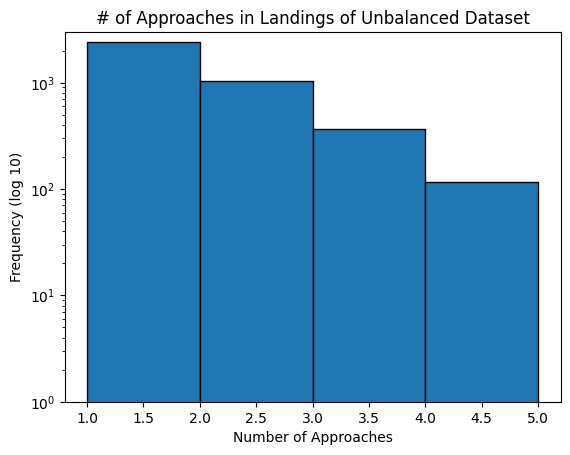

In [143]:
data = labels[:, 0]

plt.figure()
y, _, _ = plt.hist(data, log=True, bins=range(1, 6), edgecolor = "black")
plt.xlabel("Number of Approaches")
plt.ylabel("Frequency (log 10)")
plt.ylim(1, max(y)*1.25 )
plt.title("# of Approaches in Landings of Unbalanced Dataset")
plt.savefig("unbalanced_1_2_3_4_approach_histogram.svg", format="svg")
#plt.close()

In [5]:
approach_1 = df.query(f"n_approaches==1 & (@start <= time <= @stop)")
approach_2 = df.query(f"n_approaches==2 & (@start <= time <= @stop)")
approach_3 = df.query(f"n_approaches==3 & (@start <= time <= @stop)")

count = approach_3.shape[0]

approach_2 = approach_2.sample(n=count, random_state=42)
approach_1 = approach_1.sample(n=count, random_state=42)
query = pd.concat([approach_1, approach_2, approach_3], axis=0)

In [6]:
len(query)

4599

In [7]:
file_name = "balanced1_2_3"
flights, labels = flights_from_query(query, file_name, load_results=True)
data = get_flight_persistances(flights, file_name, load_results=True)
len(labels)

3037

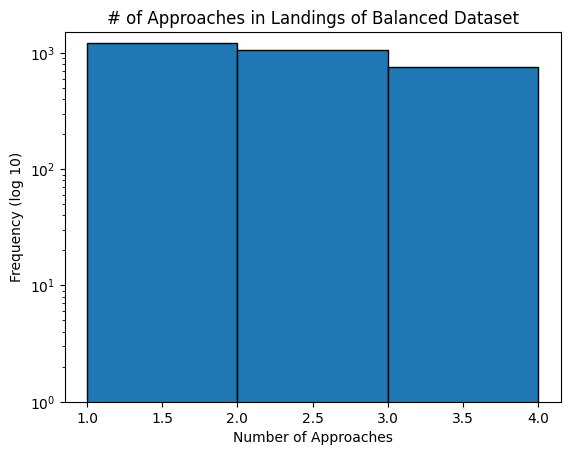

In [147]:
data = labels[:, 0]

plt.figure()
y, _, _ = plt.hist(data, log=True, bins=range(1, 5), edgecolor = "black")
plt.xlabel("Number of Approaches")
plt.ylabel("Frequency (log 10)")
plt.ylim(1, max(y)*1.25 )
plt.title("# of Approaches in Landings of Balanced Dataset")
plt.savefig("balanced_1_2_3_approach_histogram.svg", format="svg")
#plt.close()

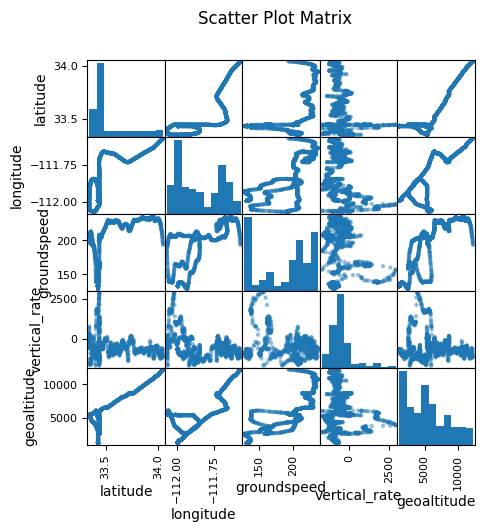

In [43]:
index = 1500

flight_data = flights[index].data[["latitude", "longitude", "groundspeed", "vertical_rate", "geoaltitude"]]

plot_scatter_matrix(flight_data)

In [23]:
trees, paths = sublevelset_persistence(flights[:1000], "geoaltitude")

100%|██████████| 1000/1000 [00:06<00:00, 158.32it/s]


In [24]:
condensed_distance_matrix = get_condensed_distance_matrix(trees, file_name=file_name, load_results=True)

Z = linkage(condensed_distance_matrix, "complete")

100%|██████████| 1000/1000 [00:20<00:00, 47.92it/s]


In [25]:
clustering = fcluster(Z, t=10, criterion='maxclust')

for i in range(1, len(np.unique(clustering))+1):
    print(f"{i}: {sum(clustering == i)}")

1: 2
2: 4
3: 190
4: 2
5: 320
6: 71
7: 263
8: 22
9: 40
10: 86


In [26]:
from matplotlib import pyplot as plt

ind = 10

flight = flights[np.where(clustering == ind)[0][0]]
tree = trees[np.where(clustering == ind)[0][0]]
points = paths[np.where(clustering == ind)[0][0]]
before = flight.data[["geoaltitude"]].to_numpy()
before = np.column_stack((np.arange(len(data)), before))

dbscan_paths  = before[remove_outliers_dbscan(before, 25, eps = 0.05)]
z_score_paths = before[remove_outliers_z_score(before)]

path_filters  = [(before, "before"), (z_score_paths, "z-score"), (dbscan_paths, "dbscan")]

fig, axs = plt.subplots(3)#, sharex=True, sharey=True)
for i, (path, name) in enumerate(path_filters):
    axs[i].scatter(path[:, 0], path[:, 1])
    axs[i].set_title(name)

fig.set_figheight(10)
fig.set_figwidth(10)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 1061

In [8]:
gudhi.persistence_graphical_tools.plot_persistence_diagram(tree, axes=axs[1])
print(tree)

C:\Users\tobso\Desktop\programering\masters-thesis\venv\Lib\site-packages\gudhi\persistence_graphical_tools.py:105: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")


AttributeError: 'numpy.ndarray' object has no attribute 'add_patch'

In [ ]:
fig = plt.scatter(points[:, 1], points[:, 0])
plt.show()